In [3]:
import lsrl
from tests.test_ua_vec2vec import TestUAVec2Vec
from tests.test_ua_tok2tok import TestUATok2TokSimplification, TestUATok2TokBuldingSteps
import copy
import numpy as np
from collections import defaultdict
import tqdm.notebook as tqdm
from matplotlib import pyplot as plt
import pandas
import seaborn as sns
from matplotlib.colors import LogNorm
from joblib import Parallel, delayed
from itertools import product

# Test the effect of parameter noise on the Vec2Vec model

In [ ]:
overall_results = defaultdict(list)

n_targets = 25

def process_one_target(random_seed: int, noise_level: float, conditional_mode: str):

    # set the random seed
    np.random.seed(random_seed)

    # creates a target function to estimate
    target = lsrl.utils.create_test_target_function(
        in_dim=2,
        out_dim=2,
        n_control_points=5,
        smoothness=1,
    )

    discretization_levels = 8

    # creates the prompt describing the target function
    prompts = lsrl.utils.construct_prompt(
        target,
        in_dim=2,
        out_dim=2,
        N=discretization_levels,
    )

    # random samples from the hypercube where we evaluate the quality of the approximation
    test_x_vals = np.random.random((10, 2))
    test_y_vals = np.array([target(x) for x in test_x_vals])

    inner_results = dict()

    # PREPARE THE ORIGINAL (UNNOISED MODEL)
    tmp_test_constructor = TestUAVec2Vec()
    tmp_test_constructor.conditional_mode = conditional_mode
    tmp_test_constructor.mode = lsrl.MatrixMode.NUMERIC
    tmp_test_constructor.make_plots = False
    tmp_test_constructor.setUp()
    model_original = copy.deepcopy(tmp_test_constructor.simplified)

    # this hook records the states during the unnoised pass
    # we want to input the unnoised states at each step rather than the noisy outputs
    # that's because the errors will otherwise blow up just because of the larger number of steps
    # and this prevents us to conclude whether that's due to the f_ifelse implementation
    # this way these results are independent of the prompt length
    states = defaultdict(list)
    def record_state_hook(s, model, self, *args, **kwargs):
        if isinstance(self, lsrl.LinState):
            node_idx = model.topological_sort().index(self)
            s[node_idx].append(copy.deepcopy(self._state))

    # add the hook that records outputs to all nodes
    for node in model_original.graph().nodes():
        node.hooks["before_forward"].append(lambda self, *args, **kwargs: record_state_hook(states, model_original, self, *args, **kwargs))

    # PREPARE THE NOISY MODEL
    model_noisy = copy.deepcopy(tmp_test_constructor.simplified)

    # go through the nodes and each node's Matrix type attribute and add a little gaussian noise to it
    # remember that the Matrices are scipy sparse matrices
    if noise_level != 0:
        for node in model_noisy.graph().nodes():
            for attr in node.__dict__:
                if isinstance(getattr(node, attr), lsrl.Matrix) and attr in ["A", "B", "b", "bias"]:
                    new_data = getattr(node, attr).matrix.data + np.random.normal(0, noise_level, getattr(node, attr).matrix.data.shape)
                    new_matrix = copy.deepcopy(getattr(node, attr))
                    new_matrix.matrix.data = new_data
                    setattr(node, attr, new_matrix)

    # add a hook to the LinStates setting the state to the unnoised one. 
    # That's because we want to evaluate the effect of noising without complicating 
    # the analysis with error accumulation through the states. If didn't do that, 
    # the error rate would be monotonically increasing in the prompt length
    def fix_state_hook(model, self, *args, **kwargs):
        if isinstance(self, lsrl.LinState):
            node_idx = model.topological_sort().index(self)
            original_state = states[node_idx].pop(0)
            # print(f"replacing state {self._state.numpy().flatten()} with {original_state.numpy().flatten()}")
            self._state = original_state

    for node in model_noisy.graph().nodes():
        if isinstance(node, lsrl.LinState):
            node.hooks["before_forward"].append(lambda self, *args, **kwargs: fix_state_hook(model_noisy, self, *args, **kwargs))

    # EVALUATE AT ALL INPUTS
    results_original = []
    results_noisy = []
    
    for x_val in test_x_vals:
        first_input = np.concatenate((x_val, np.zeros(tmp_test_constructor.target_fun_output_dim + 1)))
        full_inputs = np.vstack((first_input, prompts))
        states.clear() 
        results_original.append(model_original(full_inputs.T).numpy()[:, -1].flatten())
        results_noisy.append(model_noisy(full_inputs.T).numpy()[:, -1].flatten())

    error_noisy = np.linalg.norm(np.array(results_noisy)-test_y_vals, axis=1)
    inner_results[(conditional_mode, noise_level)] = np.mean(error_noisy)
    
    return inner_results

    
# run n_targets instances in parallel and combine their results
modes = ["multiplicative", "direct", "optimized", "step_optimized", "multiplicative_optimized"]
results = Parallel(n_jobs=16)(delayed(process_one_target)(i, noise, mode) for i, noise, mode in tqdm.tqdm(list(product(range(n_targets), [0, 1e-3, 1e-5, 1e-7, 1e-9], modes))))

for res in results:
    for k, v in res.items():
        overall_results[k].append(v)

df = pandas.DataFrame({"conditional_mode": m, "Noise level": n, "Average difference": e} for (m, n), l in overall_results.items() for e in l)
df.to_csv("noise_robustness_vec2vec.csv")

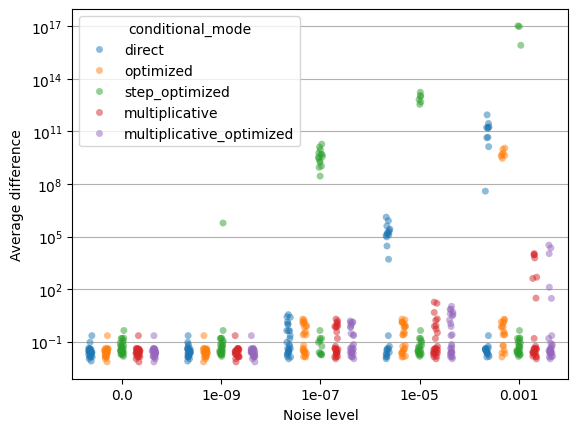

In [5]:
df = pandas.read_csv("noise_robustness_vec2vec.csv")
sns.stripplot(
    hue="conditional_mode", 
    y="Average difference", 
    x="Noise level", 
    data=df, 
    log_scale=True,
    dodge=True,
    hue_order=["direct", "optimized", "step_optimized", "multiplicative", "multiplicative_optimized"],
    alpha=0.5,
 )
plt.grid(axis="y", which="both")
plt.savefig("noise_effect_vec2vec.pdf", bbox_inches="tight")

# Test the effect of parameter noise on the Tok2Tok model

In [ ]:
overall_results = defaultdict(list)

n_targets = 25

def process_one_target(random_seed: int, noise_level: float, conditional_mode: str):

    # set the random seed
    np.random.seed(random_seed)

    # create a random map for us to model
    tmp = TestUATok2TokBuldingSteps()
    tmp.mode = lsrl.MatrixMode.NUMERIC
    tmp.conditional_mode = "direct"
    tmp.seq_len = 10
    tmp.n_samples = 20
    tmp.setUp()

    expected = []
    full_inputs = []

    inner_results = dict()

    # generate test samples
    while len(expected) < 5:
        x, y, full_input = tmp.prep_random_input()

        # prevent repetitions
        if any([(x == fi[: len(x)]).all() for fi in full_inputs]):
            continue

        full_inputs.append(full_input)
        expected.append(y)

    # PREPARE THE ORIGINAL (UNNOISED MODEL)
    tmp_test_constructor = TestUATok2TokSimplification()
    tmp_test_constructor.conditional_mode = conditional_mode
    tmp_test_constructor.mode = lsrl.MatrixMode.NUMERIC
    tmp_test_constructor.make_plots = False
    tmp_test_constructor.seq_len = tmp.seq_len
    tmp_test_constructor.n_samples = tmp.n_samples
    if random_seed != 0:
        tmp_test_constructor.no_save = True
    tmp_test_constructor.setUp()
    model_original = copy.deepcopy(tmp_test_constructor.simplified)

    states = defaultdict(list)
    def record_state_hook(s, model, self, *args, **kwargs):
        if isinstance(self, lsrl.LinState):
            node_idx = model.topological_sort().index(self)
            s[node_idx].append(copy.deepcopy(self._state))

    # add the hook that records outputs to all nodes
    for node in model_original.graph().nodes():
        node.hooks["before_forward"].append(lambda self, *args, **kwargs: record_state_hook(states, model_original, self, *args, **kwargs))

    # PREPARE THE NOISY MODEL
    model_noisy = copy.deepcopy(tmp_test_constructor.simplified)
    noise_activations = list()

    # go through the nodes and each node's Matrix type attribute and add a little gaussian noise to it
    # remember that the Matrices are scipy sparse matrices
    if noise_level != 0:
        for node in model_noisy.graph().nodes():
            for attr in node.__dict__:
                if isinstance(getattr(node, attr), lsrl.Matrix) and attr in ["A", "B", "b", "bias"]:
                    new_data = getattr(node, attr).matrix.data + np.random.normal(0, noise_level, getattr(node, attr).matrix.data.shape)
                    new_matrix = copy.deepcopy(getattr(node, attr))
                    new_matrix.matrix.data = new_data
                    setattr(node, attr, new_matrix)

    # add a hook to the LinStates setting the state to the unnoised one. 
    # That's because we want to evaluate the effect of noising without complicating 
    # the analysis with error accumulation through the states. If didn't do that, 
    # the error rate would be monotonically increasing in the prompt length
    def fix_state_hook(model, self, *args, **kwargs):
        if isinstance(self, lsrl.LinState):
            node_idx = model.topological_sort().index(self)
            original_state = states[node_idx].pop(0)
            self._state = original_state


    for node in model_noisy.graph().nodes():
        if isinstance(node, lsrl.LinState):
            node.hooks["before_forward"].append(lambda self, *args, **kwargs: fix_state_hook(model_noisy, self, *args, **kwargs))

    # EVALUATE AT ALL INPUTS
    results_original = []
    results_noisy = []
    for full_input in full_inputs:
        states.clear() 
        noise_activations.clear()
        results_original.append(model_original(full_input[None, :]).numpy()[:, -tmp_test_constructor.seq_len:].flatten())
        results_noisy.append(model_noisy(full_input[None, :]).numpy()[:, -tmp_test_constructor.seq_len:].flatten())

    inner_results[(conditional_mode, noise_level)] = np.mean(np.average(np.array(expected).round() == np.array(results_noisy).round()))
            
    return inner_results

modes = ["multiplicative", "direct", "optimized", "step_optimized", "multiplicative_optimized"]
results = Parallel(n_jobs=16)(delayed(process_one_target)(i, noise, mode) for i, noise, mode in tqdm.tqdm(list(product(range(n_targets), [0, 1e-3, 1e-5, 1e-7, 1e-9], modes))))

for res in results:
    for k, v in res.items():
        overall_results[k].append(v)

df = pandas.DataFrame({"conditional_mode": m, "Noise level": n, "Wrong outputs (%)": 100*(1-e)} for (m, n), l in overall_results.items() for e in l)
df.to_csv("noise_robustness_tok2tok.csv")

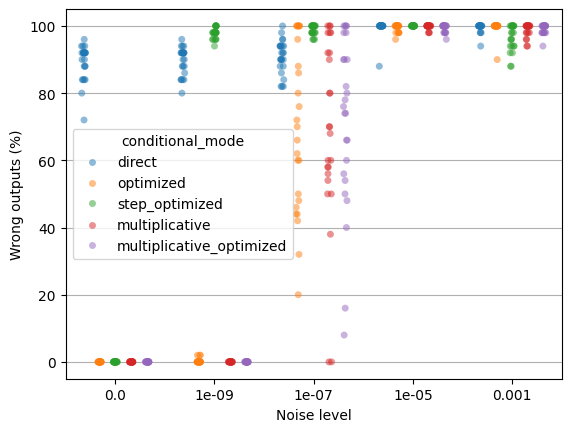

In [6]:
plt.figure()
df = pandas.read_csv("noise_robustness_tok2tok.csv")
sns.stripplot(
    hue="conditional_mode", 
    y="Wrong outputs (%)", 
    x="Noise level", 
    dodge=True,
    data=df,
    hue_order=["direct", "optimized", "step_optimized", "multiplicative", "multiplicative_optimized"],
    # log_scale=True,
    alpha=0.5,
)
plt.grid(axis="y", which="both")
plt.savefig("noise_effect_tok2tok.pdf", bbox_inches="tight")